<a href="https://colab.research.google.com/github/egrinstein/pytorch-voice-activity-detection-rnn/blob/master/NeuralVoiceActivityDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Voice Activation Detection
This notebook was an experiment of training a simple RNN with one hidden layer for Voice Activity Detection.

The data used for this experiment can be found [here](https://github.com/jtkim-kaist/VAD). 

Training on Google Colab takes less than half an hour. If you want to reproduce the training, you should add the aforementioned data to your Google Drive, and change the key "kaist_dataset_path" in the "params" dict below.

### Parameters

In [0]:
params = {
    # Data input
    'kaist_dataset_path':'My Drive/data/kaist-vad-dataset.zip', 
    
    # The dataset is hosted at:
    #http://sail.ipdisk.co.kr/publist/VOL1/Database/VAD_DB/Recorded_data.zip
    # The repository for it is at:
    #https://github.com/jtkim-kaist/VAD
    
    # Training params
    'n_epochs': 25,
    'learning_rate':5e-3,
    'loss_function':nn.BCEWithLogitsLoss,
    'optimizer':T.optim.Adam,

    # Model parameters
    'frame_size':320, # 320/16000 = 20ms
    'hidden_layer_size':200,
    'memory_size':64,
}

### File Loader

In [0]:
from google.colab import drive
import json
import librosa
import numpy as np
import os
import scipy
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tarfile
import tempfile
from tqdm import tqdm_notebook as tqdm
from zipfile import  ZipFile
import torch as T
# Configure Pytorch to use the GPU
device = T.device("cuda:0" if not T.cuda.is_available() else "cpu")

def mount_google_drive():
  drive.mount('/gdrive')
  %cd /gdrive

 
def load_wav(path, sr=22050):
  "Load a wav phrase from the vad dataset"
  return librosa.load(path, sr=sr)[0]


def load_sample(dataset_sample):
  "dataset_sample (tuple): (wave_path, json_path)"
  return load_wav(dataset_sample[0]), load_json(dataset_sample[1])


def load_kaist_dataset(dataset_zip_path):
  file_names = ['bus_stop', 'construction_site', 'park', 'room']
  temp_dir = tempfile.TemporaryDirectory()
  with ZipFile(dataset_zip_path) as f:
    f.extractall(temp_dir.name)

  def load_sample(sample_name):
    sample_path = os.path.join(temp_dir.name, sample_name)
    x = load_wav(sample_path + '.wav', sr=16000)
    y = loadmat(sample_path + '.mat')['y_label']
    return x, y

  return [load_sample(name) for name in file_names]


def wave_to_frames(wave, frame_size):
  """Transforms a wave into a matrix of dimension (n, frame_size),
  where n is the number of frames contained in the wave. This means 
  the wave ending of the wave may be truncated by up to frame_size - 1 samples  
  """

  n_frames = wave.shape[0]//frame_size
  frame_matrix = np.reshape(wave[:n_frames*frame_size],
                            (n_frames, frame_size))
  return frame_matrix  


def get_mode(frames, axis=1):
  """Used to reduce a frame into a single number, 
  0/1 in the case of a detection frame"""
  return scipy.stats.mode(frames, axis=axis)[0]


def to_tensor(matrix):
  return T.from_numpy(matrix).float().to(device)


def prepare_kaist_dataset(dataset, frame_size):
  prepared_dataset = {}

  def prepare_sample(sample):
    frames_x = wave_to_frames(sample[0], frame_size)
    frames_y = wave_to_frames(sample[1], frame_size)
    labels_y = get_mode(frames_y)
    return to_tensor(frames_x), to_tensor(labels_y) 
  prepared_samples = [prepare_sample(s) for s in dataset]

  min_sample_size = min([p[0].shape[0] for p in prepared_samples])
  
  X = T.stack([s[0][:min_sample_size] for s in prepared_samples])
  Y = T.stack([s[1][:min_sample_size] for s in prepared_samples])

  return X, Y


### Detection RNN Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class VadRnn(nn.Module):
    def __init__(self, frame_size, memory_size, hidden_layer_dim):
        super(VadRnn, self).__init__()
            
        self.frame_size = frame_size
        self.input_size = frame_size
        self.memory_size = memory_size
        self.hidden_layer_dim = hidden_layer_dim
        self.hidden_layer = nn.Linear(self.input_size + memory_size, self.hidden_layer_dim)
        self.output_layer = nn.Linear(self.hidden_layer_dim, 1)
        self.memory_layer = nn.Linear(self.hidden_layer_dim, self.memory_size)
        self.to(device)

    def forward(self, frame, memory):
        combined = T.cat((frame, memory), 1)
        activations = F.relu(self.hidden_layer(combined))
        new_memory = self.memory_layer(activations)
        output = self.output_layer(activations)
        #output = T.sigmoid(output) # Uncomment if not using a loss function with digits
        return output, new_memory.data

    def init_memory(self, batch_size=1):
        return T.zeros(batch_size, self.memory_size, device=device, requires_grad=False)

### Detector

In [0]:

class VadDetector:
  """This class is a wrapper around the neural network, 
  where funcionality such as hangover, minimum speech time, etc
  should be implemented.
  """
  def __init__(self, params, model, threshold=0.5):
    self.params = params
    self.model = model
    self.model.eval()
    self.threshold = threshold # Every output above this threshold will be viewed as 
    # a detection by the neural network.

    self.memory = self.model.init_memory()

  def step(self, frame):
    """This method should be used for frame processing
    args:
      frame (tensor): Represents one frame of a sample
    
    returns: (tensor) frame_size dim tensor containing exclusively 0s or 1s
      
    """
    model_result, self.memory = self.model.forward(frame[None,:], self.memory)
    model_result = T.sigmoid(model_result)[0]
    detection_result = self.apply_threshold(model_result)
    
    return detection_result*T.ones(self.params['frame_size'], device=device)
  
  def step_many(self, frames):
    "This method should be used for analyzing a matrix of consecutive frames"
    n_frames = frames.shape[0]
    results = [self.step(frames[i,:]) for i in range(n_frames)]
    #self.memory = self.model.init_memory()
    return T.cat(results)
  
  def apply_threshold(self, x):
    "Returns true if the detection value x surpasses the threshold"
    return 1 if x > self.threshold else 0



### Training

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_loss(train_loss_history):
  sample_ind = range(len(train_loss_history))
  fig, ax = plt.subplots()
  ax.plot(sample_ind, train_loss_history)
  ax.set_title('Train Loss over time')
  ax.set_xlabel('epoch')
  ax.set_ylabel('Binary crossentropy loss value')
  fig.show()


def train(dataset, model, params):
    train_data_x, train_data_y = dataset[0], dataset[1]
    n_training_samples = train_data_x.shape[0]
    n_steps = train_data_x.shape[1]

    loss_function = params['loss_function']()
    optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
    epoch_loop = tqdm(range(params['n_epochs']))

    loss_history = []
    val_loss_history = []

    for i in epoch_loop:  
      current_loss = 0
      steps_loop = tqdm(range(n_steps))
      memory = model.init_memory(batch_size=n_training_samples)
      loss = 0
      for n_step in steps_loop:
        optimizer.zero_grad()
        x, y = train_data_x[:, n_step, :], train_data_y[:, n_step, :]
        output, memory.data = model(x, memory)
        step_loss = loss_function(output, y)
        loss += step_loss

      loss.backward()
      optimizer.step()
    
      loss_history.append(loss)
      steps_loop.set_description('L(Train)=%.2f' %(loss))
      
      
    plot_loss(loss_history)

### Model Evaluation

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve


def evaluate_model(model, params, X_train, y_train, X_test, y_test):
  def compute_metrics(X, y):
    detector = VadDetector(params, model)
    detections = detector.step_many(X).cpu().detach().numpy().flatten()
    y = y.repeat(1, params['frame_size']).cpu().numpy().flatten()
    fpr, tpr, thresholds = roc_curve(y, detections)
    score = roc_auc_score(y, detections)
    return fpr, tpr, score

  fig = plt.figure()
  ax = plt.axes()
  fig.suptitle('ROC Curves for training and testing datasets')
  
  fpr, tpr, score = compute_metrics(X_test[0], y_test[0])
  ax.plot(fpr, tpr, label='Test (AUC = %f)' %score)

  for ind in range(X_train.shape[0]):
    fpr, tpr, score = compute_metrics(X_train[ind], y_train[ind])
    ax.plot(fpr, tpr, label='Train %d (AUC = %f)' %(ind, score))


  ax.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")

  fig.show()

## Demo

### Demo 1: Training

In [0]:
from pprint import pprint
mount_google_drive()

if os.path.exists(params['kaist_dataset_path']):
  print("Loading audios and ground truths...")
  dataset_files = load_kaist_dataset(params['kaist_dataset_path'])
  print("Converting audio into frame tensors...")
  dataset = prepare_kaist_dataset(dataset_files, params['frame_size'])
  X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.25)
  model = VadRnn(params['frame_size'], params['memory_size'], params['hidden_layer_size'])
else:
  print("file %s doesn't exist. Files in your drive:" %params['dataset_path'])
  pprint(os.listdir())
  X_train, X_test, y_train, y_test = None, None, None, None
  model = None

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
Loading audios and ground truths...
Converting audio into frame tensors...


VadRnn(
  (hidden_layer): Linear(in_features=384, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
  (memory_layer): Linear(in_features=200, out_features=64, bias=True)
)
Starting training. Parameters are:
{'frame_size': 320,
 'hidden_layer_size': 200,
 'kaist_dataset_path': 'My Drive/data/kaist-vad-dataset.zip',
 'learning_rate': 0.005,
 'loss_function': <class 'torch.nn.modules.loss.BCEWithLogitsLoss'>,
 'memory_size': 64,
 'n_epochs': 25,
 'optimizer': <class 'torch.optim.adam.Adam'>}


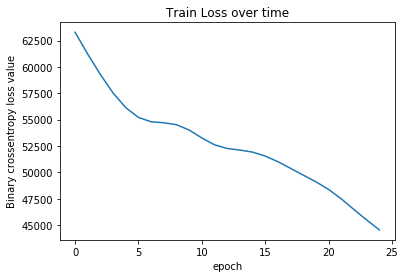

In [0]:

print(model)
print("Starting training. Parameters are:")
pprint(params)
train((X_train, y_train), model, params)


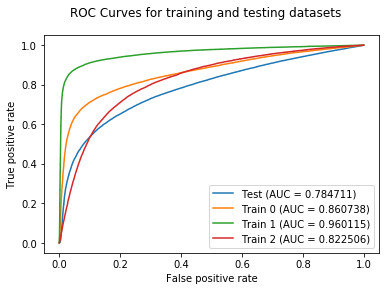

In [0]:
evaluate_model(model, params, X_train, y_train, X_test, y_test)

### Demo 2: Testing the trained model

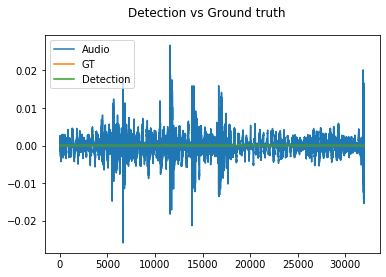

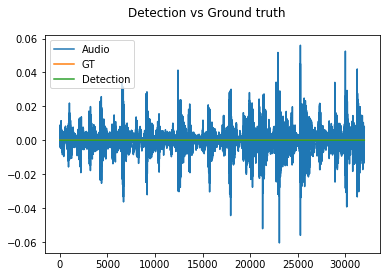

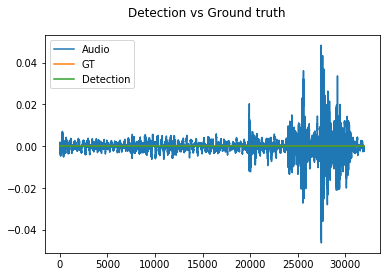

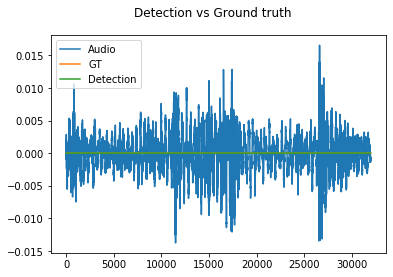

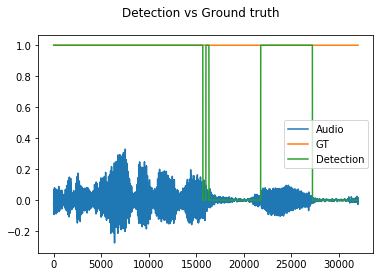

In [0]:
import random

def prepare_signal(signal):
  # see if you can get rid of this "detach"
  return signal.detach().flatten().cpu().numpy()

def plot_detection_with_ground_truth(wave, 
                                     detection, 
                                     ground_truth):

  # Flatten frame matrices, send to numpy
  detection = prepare_signal(detection)
  ground_truth = prepare_signal(ground_truth)
  wave = prepare_signal(wave)
  n = detection.shape[0]

  sample_ind = range(n)
  fig = plt.figure()
  ax = plt.axes()
  fig.suptitle('Detection vs Ground truth')

  ax.plot(sample_ind, wave, label='Audio')
  ax.plot(sample_ind, ground_truth, label='GT')
  ax.plot(sample_ind, detection, label='Detection')
  ax.legend()
  fig.show()


# 1. Load detector
detector = VadDetector(params, model, threshold=0.25)

# pull some random snippets from the dataset
snippet_size = 100
n_snippets = 5

# Switch between X_train[0/1/2] and X_test[0] to see how the detector for each set.
X = X_train[1]
ground_truths = y_train[1]
detections = detector.step_many(X)

for n in range(n_snippets):
  ind = random.randrange(X.shape[0] - snippet_size) 
  wave = X[ind:ind+snippet_size, :]
  ground_truth = ground_truths[ind:ind+snippet_size, :]

  detection = detections[ind*params['frame_size']:(ind+snippet_size)*params['frame_size']]

  ground_truth = ground_truth.repeat(1, params['frame_size'])
  plot_detection_with_ground_truth(wave, detection, ground_truth)